In [84]:
import pandas as pd
import sys
sys.path.append('..')
from utils import RewardModelWrapper, get_percent_chosen
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.special import softmax
import numpy as np
from calc_ece import get_metrics
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy import special

In [31]:
df = pd.read_csv('../data/test_sets/openai_summarize_from_feedback/english_original.csv').fillna('')
df

,prompt,chosen,rejected
0,This is my first post so please be kind :)\n\n...,"I never dated/flirted as an adult, now I'm not...","Just came out of 8 year relationship, don't kn..."
1,This is my first post so please be kind :)\n\n...,"Just came out of 8 year relationship, don't kn...",Don't know how to date/flirt/flirt with someon...
2,This is my first post so please be kind :)\n\n...,"I never dated/flirted as an adult, now I'm not...",Don't know how to date/flirt/flirt with someon...
3,This is my first post so please be kind :)\n\n...,"Just came out of 8 year relationship, don't kn...",Started a long-term relationship as a teenager...
4,This is my first post so please be kind :)\n\n...,Started a long-term relationship as a teenager...,Don't know how to date/flirt/flirt with someon...
...,...,...,...
83797,I don't know how to ask this without it soundi...,"Boyfriend talks very slowly, I feel frustrated...","Boyfriend talks very slowly, I feel frustrated..."
83798,I honestly do not care anymore. \n\nExcluding ...,Medical field looks like its going to hell. Wh...,Life sucks if you don't have money. Medical fi...
83799,Someone I consider to be a best friend and I a...,"Met a guy on reddit, became best friends, met,...","Met a guy on reddit, became best friends, met,..."
83800,Me (17F) and my boyfriend (18M) have been goin...,Had a drunken peck with a girl at a party last...,Had a drunken peck with a girl at a party last...


In [32]:
for c in df.columns:
    df = df[~df.duplicated(subset=c)].reset_index(drop=True)
df

,prompt,chosen,rejected
0,This is my first post so please be kind :)\n\n...,"I never dated/flirted as an adult, now I'm not...","Just came out of 8 year relationship, don't kn..."
1,(Full background under my submitted)\n\nI deci...,Ex gf and I split up after months of planning ...,know all our plans are now gone after break up...
2,Me and my girlfriend have been together for ab...,Girlfriend is very jealous of my past partners...,My girlfriend is envious of my past relationsh...
3,"On Sunday, I ran my first 10-mile race. While ...",Running 10-miler. Sex drive spike leading up t...,Previous high sex drive prior to running race ...
4,"This is kinda non-romantic, I suppose. I recen...",drunkenly told a girl I thought she was cute t...,accidentally made a hasty judgement about a ne...
...,...,...,...
6225,"I have a neutered, 11-year-old cat, named [Mid...",My boyfriend and I are getting together with o...,I'm moving my cats into an apartment together ...
6226,23 year old male here. I don't know what else ...,overall message here though is that I hate the...,is basically how much I want to be out of the ...
6227,"So long story short, my GF [25f] broke up with...",Long term GF dumped me. Tried to go NC but nee...,"My GF dumped me, then 'cheated' on me, and now..."
6228,I don't have anything to hide. Maybe it's a li...,"Stopped communicating with my ex-girlfriend, b...",Girl I had a thing with keeps sneaking a look ...


In [33]:
to_calibrate = df#.sample(1000, random_state=42).reset_index(drop=True)
to_calibrate

,prompt,chosen,rejected
0,This is my first post so please be kind :)\n\n...,"I never dated/flirted as an adult, now I'm not...","Just came out of 8 year relationship, don't kn..."
1,(Full background under my submitted)\n\nI deci...,Ex gf and I split up after months of planning ...,know all our plans are now gone after break up...
2,Me and my girlfriend have been together for ab...,Girlfriend is very jealous of my past partners...,My girlfriend is envious of my past relationsh...
3,"On Sunday, I ran my first 10-mile race. While ...",Running 10-miler. Sex drive spike leading up t...,Previous high sex drive prior to running race ...
4,"This is kinda non-romantic, I suppose. I recen...",drunkenly told a girl I thought she was cute t...,accidentally made a hasty judgement about a ne...
...,...,...,...
6225,"I have a neutered, 11-year-old cat, named [Mid...",My boyfriend and I are getting together with o...,I'm moving my cats into an apartment together ...
6226,23 year old male here. I don't know what else ...,overall message here though is that I hate the...,is basically how much I want to be out of the ...
6227,"So long story short, my GF [25f] broke up with...",Long term GF dumped me. Tried to go NC but nee...,"My GF dumped me, then 'cheated' on me, and now..."
6228,I don't have anything to hide. Maybe it's a li...,"Stopped communicating with my ex-girlfriend, b...",Girl I had a thing with keeps sneaking a look ...


In [34]:
reward_model = RewardModelWrapper("OpenAssistant/reward-model-deberta-v3-large-v2")
to_calibrate_scores = reward_model.get_scores_df(to_calibrate)
to_calibrate_scores

  0%|          | 0/6230 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)) / torch.tensor(
/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=c2p_att.dtype)
/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWa

,chosen,rejected
0,-1.674806,2.649245
1,5.845358,3.814030
2,4.131209,-3.536682
3,5.749402,-0.966785
4,3.147734,0.167818
...,...,...
6225,2.496217,0.672028
6226,-0.443843,-2.665625
6227,6.165255,-0.633111
6228,5.754606,1.935143


In [35]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

def run_supervised_tempscaling(logits):
    """image_features, actual = get_image_features(model, dset, batch_size=128,
        device = device)
    actual = torch.IntTensor(actual).to(device).long()

    text = tokenizer([text_template.replace('{}',x) for x in dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    text_probs = (100.0 * image_features @ text_features.T)"""
    ## Setup LBGFS
    temperature = nn.Parameter((torch.ones(1)))
    args = {'temperature': temperature}
    criterion = nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')
    actual = torch.LongTensor([0] * len(logits))
    temps = []
    losses = []
    def _eval():
        loss = criterion(T_scaling(logits, args), actual)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        return loss
    optimizer.step(_eval)
    return temperature.item()


In [36]:
temp = run_supervised_tempscaling(torch.FloatTensor(to_calibrate_scores.values))
temp

2.870541572570801

In [37]:
def calc_ece_acc(logits, temperature=1):
  scores = softmax(logits / temperature, axis=1)
  y_true = np.array([0] * len(scores)) # chosen is always class 0
  preds = scores.argmax(axis=1)
  confs = scores[np.arange(len(scores)), preds]
  ece, mce, acc = get_metrics(y_true=y_true, preds=preds, confs=confs)
  return ece, acc, confs

In [38]:
orig_scores = pd.read_csv('/home/ubuntu/code/neurips2023_distshift/model_scores/deberta_v3_large/open_ai_summarize_from_feedback/english_original_scores.csv')
calc_ece_acc(orig_scores.values, temperature=1)[0]

0.14528659532547955

Temperature grid search

In [72]:
instances = ['prompt', 'response', 'prompt_and_response']

In [70]:
temps = np.arange(0.01, 20, 0.05)
base_dir = '/home/ubuntu/code/neurips2023_distshift/model_scores/deberta_v3_large/open_ai_summarize_from_feedback/word_perturb/10k_subset/trial0'
ece_dict = {}
for inst in instances:
    subeces = {}
    subdir = f'{base_dir}/{inst}'
    for perturb_level in tqdm(os.listdir(subdir)):
        scores = pd.read_csv(f'{subdir}/{perturb_level}')
        perturb_level = int(perturb_level.split('_')[0]) / 10
        eces = [calc_ece_acc(scores.values, temperature=t)[0] for t in temps]
        subeces[perturb_level] = eces
    ece_dict[inst] = subeces

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [40]:
def plot_ece_perturb(inst):
    for perturb_level in sorted(ece_dict[inst]):
        plt.plot(temps, ece_dict[inst][perturb_level], label=f'{perturb_level}', c = 'red', alpha=perturb_level + 0.1)
    plt.xlabel('Temperature')
    plt.ylabel('ECE')
    plt.suptitle('Temperature Grid Search for SummarizeFromFeedback')
    plt.title(inst)
    plt.ylim(0.0, 0.2)
    plt.legend()

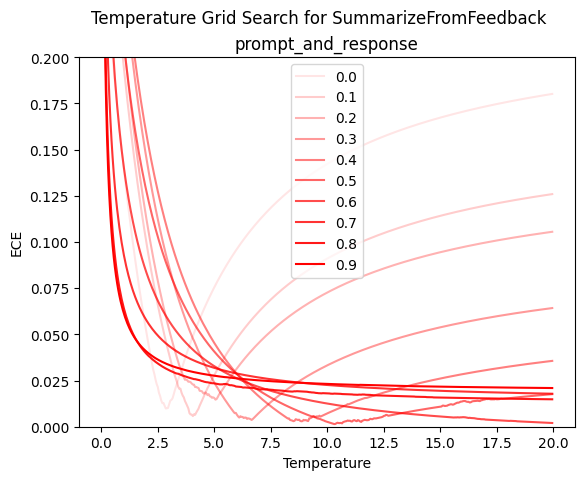

In [73]:
plot_ece_perturb('prompt_and_response')

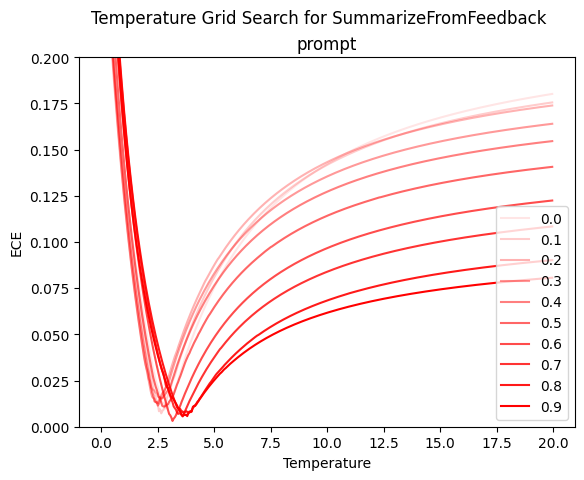

In [74]:
plot_ece_perturb('prompt')

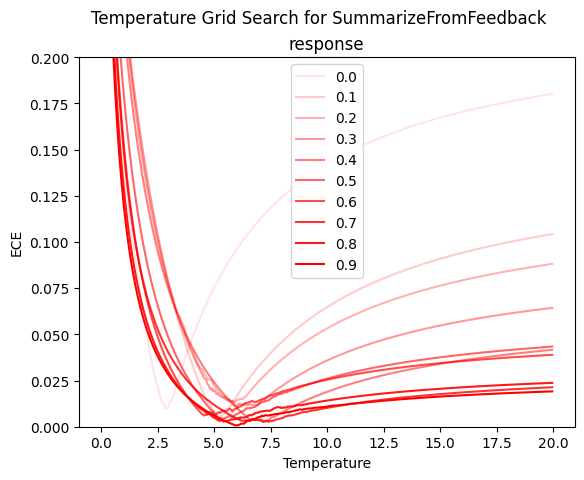

In [75]:
plot_ece_perturb('response')

In [44]:
calc_ece_acc(orig_scores.values, temperature=temp)[0]

0.009659905136881272

In [45]:
calc_ece_acc(to_calibrate_scores.values, temperature=1)[0]

0.14533945410671012

In [46]:
calc_ece_acc(to_calibrate_scores.values, temperature=temp)[0]

0.006360532771477624

In [59]:
best_temps = {}
for inst in instances:
    best_temps[inst] = {}
    for perturb_level in sorted(ece_dict[inst]):
        min_ind = np.argmin(ece_dict[inst][perturb_level])
        best_temps[inst][perturb_level] = temps[min_ind]

Text(0.5, 1.0, 'Best Temperature (Grid Search)')

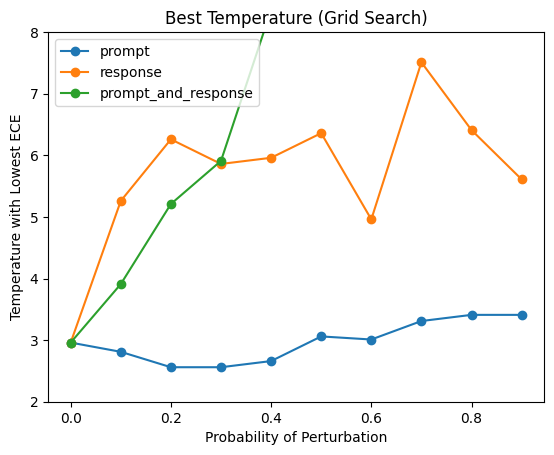

In [82]:
perturb_levels = list(sorted(ece_dict[inst]))
for inst in instances:
    plt.plot(perturb_levels, [best_temps[inst][x] for x in perturb_levels], marker='o', label=inst)
plt.ylim(2, 8)
plt.xlabel('Probability of Perturbation')
plt.ylabel('Temperature with Lowest ECE')
plt.legend()
plt.title('Best Temperature (Grid Search)')

In [78]:
ts_dict = {}
for inst in instances:
    sub_ts = {}
    subdir = f'{base_dir}/{inst}'
    for perturb_level in tqdm(os.listdir(subdir)):
        scores = pd.read_csv(f'{subdir}/{perturb_level}')
        perturb_level = int(perturb_level.split('_')[0]) / 10
        temp = run_supervised_tempscaling(torch.FloatTensor(scores.values))
        sub_ts[perturb_level] = temp
    ts_dict[inst] = sub_ts

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Text(0.5, 1.0, 'Supervised Temperature Scaling')

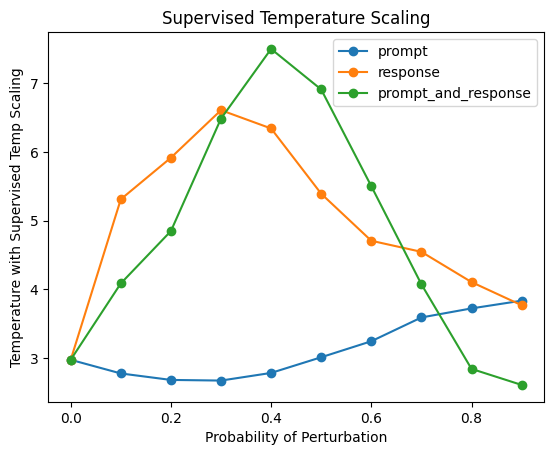

In [91]:
for inst in instances:
    plt.plot(perturb_levels, [ts_dict[inst][x] for x in perturb_levels], marker='o', label=inst)
plt.xlabel('Probability of Perturbation')
plt.ylabel('Temperature with Supervised Temp Scaling')
plt.legend()
plt.title('Supervised Temperature Scaling')

In [85]:
def energy_score(logits, temperature=1.0):
    assert logits.shape[1] == 2
    # implements energy based out of distribution detection
    return (-temperature) * special.logsumexp(logits / temperature, axis=1)

In [121]:
energy_mean_dict, energy_std_dict = {}, {}
for inst in instances:
    sub_energy_mean, sub_energy_std = {}, {}
    subdir = f'{base_dir}/{inst}'
    for perturb_level in tqdm(os.listdir(subdir)):
        scores = pd.read_csv(f'{subdir}/{perturb_level}')
        perturb_level = int(perturb_level.split('_')[0]) / 10
        energies = energy_score(scores.values)
        mean_energy = energies.mean()
        std_energy = energies.std()
        sub_energy_mean[perturb_level] = mean_energy
        sub_energy_std[perturb_level] = std_energy
    energy_mean_dict[inst] = sub_energy_mean
    energy_std_dict[inst] = sub_energy_std

100%|██████████| 10/10 [00:00<00:00, 166.99it/s]


Text(0.5, 0.98, 'Energy Score (T=1)')

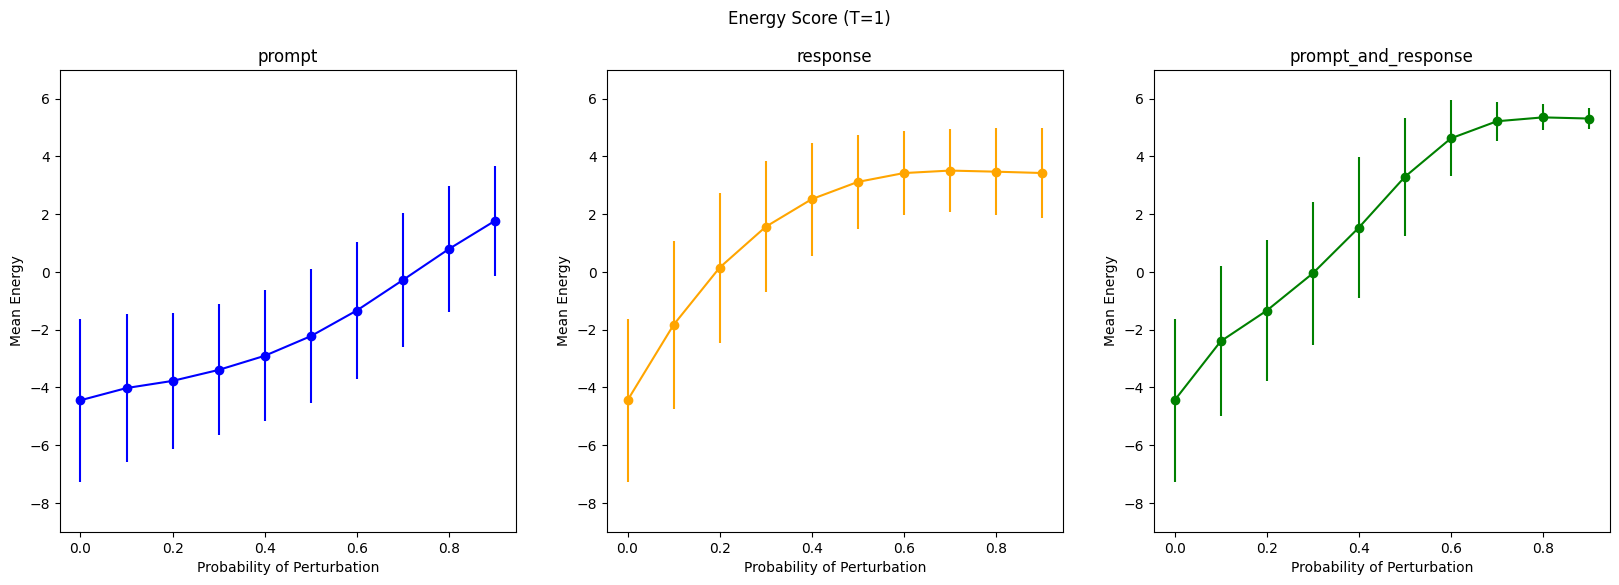

In [122]:
fig, ax = plt.subplots(1,3, figsize=(20,6))
colors = ['b', 'orange', 'g']
for i, inst in enumerate(instances):
    #plt.plot(perturb_levels, [energy_mean_dict[inst][x] for x in perturb_levels], marker='o', label=inst)
    ax[i].errorbar(perturb_levels, [energy_mean_dict[inst][x] for x in perturb_levels], yerr = [energy_std_dict[inst][x] for x in perturb_levels],  marker='o', label=inst, color=colors[i])
    ax[i].set_xlabel('Probability of Perturbation')
    ax[i].set_ylabel('Mean Energy')
    ax[i].set_title(inst)
    ax[i].set_ylim(-9,7)
fig.suptitle('Energy Score (T=1)')

In [123]:
energy_mean_dict, energy_std_dict = {}, {}
for inst in instances:
    sub_energy_mean, sub_energy_std = {}, {}
    subdir = f'{base_dir}/{inst}'
    for perturb_level in tqdm(os.listdir(subdir)):
        scores = pd.read_csv(f'{subdir}/{perturb_level}')
        perturb_level = int(perturb_level.split('_')[0]) / 10
        energies = energy_score(scores.values, temperature=best_temps[inst][perturb_level])
        mean_energy = energies.mean()
        std_energy = energies.std()
        sub_energy_mean[perturb_level] = mean_energy
        sub_energy_std[perturb_level] = std_energy
    energy_mean_dict[inst] = sub_energy_mean
    energy_std_dict[inst] = sub_energy_std

100%|██████████| 10/10 [00:00<00:00, 163.91it/s]


Text(0.5, 0.98, 'Energy Score (T=Best Temp)')

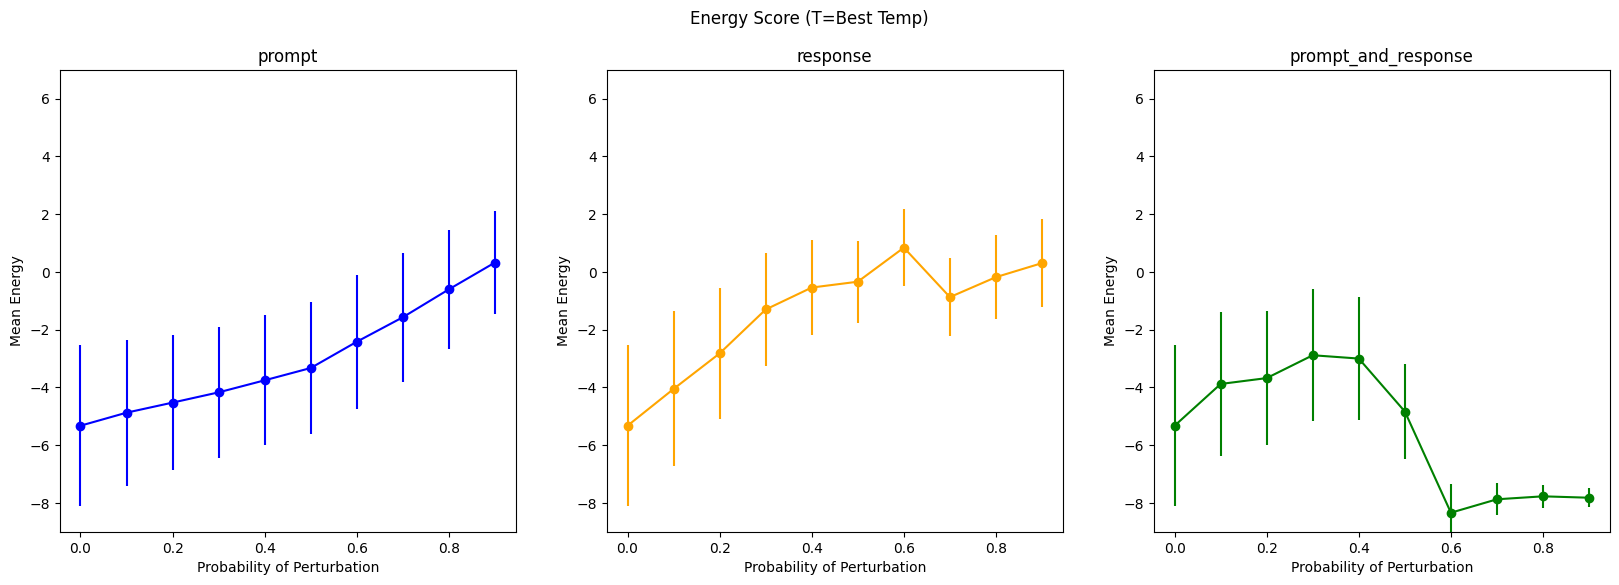

In [124]:
fig, ax = plt.subplots(1,3, figsize=(20,6))
colors = ['b', 'orange', 'g']
for i, inst in enumerate(instances):
    #plt.plot(perturb_levels, [energy_mean_dict[inst][x] for x in perturb_levels], marker='o', label=inst)
    ax[i].errorbar(perturb_levels, [energy_mean_dict[inst][x] for x in perturb_levels], yerr = [energy_std_dict[inst][x] for x in perturb_levels],  marker='o', label=inst, color=colors[i])
    ax[i].set_xlabel('Probability of Perturbation')
    ax[i].set_ylabel('Mean Energy')
    ax[i].set_title(inst)
    ax[i].set_ylim(-9,7)
fig.suptitle('Energy Score (T=Best Temp)')